In [1]:
import sys
import os
from dotenv import load_dotenv
from pydantic import BaseModel, Field
from IPython.display import Image, display
from enum import Enum
from operator import add
from typing import TypedDict, Annotated, List, Dict, Any, Optional
from langchain_openai import ChatOpenAI
from langchain_core.tools import Tool
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langgraph.graph import add_messages, StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver
from langchain_community.utilities import GoogleSerperAPIWrapper

load_dotenv(override=True)

True

In [2]:
mini_llm = ChatOpenAI(model="gpt-4o-mini")
serper = GoogleSerperAPIWrapper()
tool_web_search = Tool(
    name="web_search",
    func=serper.run,
    description="Useful for when you need more information from the web about a query"
)
llm_with_web_search_tools = mini_llm.bind_tools([tool_web_search])

In [3]:
reasoning_llm = ChatOpenAI(model="gpt-5")

In [4]:
class DomainTask(BaseModel):
    """Schema for individual domain tasks"""
    domain: str = Field(description="The domain name (compute, network, storage, database, etc)")
    task_description: str = Field(description="Clear description of the task for this domain")
    requirements: List[str] = Field(description="Key requirements and constraints for this domain")
    deliverables: List[str] = Field(description="Expected deliverables for this domain")

In [5]:
class TaskDecomposition(BaseModel):
    """Schema for the complete task decomposition"""
    user_problem: str = Field(description="The original user problem")
    decomposed_tasks: List[DomainTask] = Field(description="List of domain-specific tasks")
    overall_architecture_goals: List[str] = Field(description="High-level architecture goals")
    constraints: List[str] = Field(description="Global constraints that apply to all domains")

In [6]:
def merge_dicts(left: Dict[str, Any], right: Dict[str, Any]) -> Dict[str, Any]:
    """Merge two dictionaries, with right taking precedence over left."""
    result = left.copy()
    result.update(right)
    return result

def last_value(left: Any, right: Any) -> Any:
    """Keep the last value (right takes precedence)."""
    return right

class State(TypedDict):
    messages: Annotated[List, add_messages]
    user_problem: Annotated[str, last_value]
    # current_phase: Annotated[Phase, last_value]
    iteration_count: Annotated[int, last_value]
    
    architecture_domain_tasks: Annotated[Dict[str, Dict[str, Any]], merge_dicts]

    architecture_components: Annotated[Dict[str, Dict[str, Any]], merge_dicts]

    proposed_architecture: Annotated[Dict[str, Any], merge_dicts]

    validation_feedback: Annotated[List[Dict[str, Any]], add]
    audit_feedback: Annotated[List[Dict[str, Any]], add]

    factual_errors_exist: Annotated[bool, last_value]
    design_flaws_exist: Annotated[bool, last_value]

    final_architecture: Annotated[Optional[Dict[str, Any]], last_value]
    architecture_summary: Annotated[Optional[str], last_value]

In [7]:
def architect_supervisor(state: State) -> State:
    """
    This function orchestrates the architecture generation process using structured output for task decomposition.
    """

    system_prompt = f"""
    You are an architect supervisor for AWS cloud architecture.
    Your role is to decompose the user's problem into structured domain-specific tasks and assign them to different architect domain agents.

    User Problem: {state["user_problem"]}
    Current Iteration: {state["iteration_count"]}

    Available feedback:
    - Validation feedback: {state["validation_feedback"]}
    - Audit feedback: {state["audit_feedback"]}

    Proposed Architecture: {state["proposed_architecture"]}
    Architecture Components: {state["architecture_components"]}

    Decompose the problem into structured tasks for these domains:
    1. Compute Architect (EC2, Lambda, ECS, EKS, Auto Scaling, etc.)
    2. Network Architect (VPC, Subnets, ALB, CloudFront, Route 53, Security Groups, etc.)
    3. Storage Architect (S3, EBS, EFS, etc.)
    4. Database Architect (RDS, DynamoDB, ElastiCache, etc.)

    For each domain, provide:
    - Clear task description
    - Key requirements and constraints
    - Expected deliverables

    Also provide overall architecture goals and global constraints.
    """

    # Create LLM with structured output
    structured_llm = reasoning_llm.with_structured_output(TaskDecomposition)
    
    messages = [SystemMessage(content=system_prompt)]
    response = structured_llm.invoke(messages)

    # Store the structured decomposition in state
    new_state = state.copy()
    new_state["messages"].append(AIMessage(content=f"Task decomposition completed: {response.user_problem}"))
    
    # Store the structured decomposition for use by domain agents
    new_state["architecture_domain_tasks"] = {
        "decomposition": response.dict(),
        "overall_goals": response.overall_architecture_goals,
        "constraints": response.constraints
    }
    
    # Extract domain tasks for each agent
    for task in response.decomposed_tasks:
        new_state["architecture_domain_tasks"][task.domain] = {
            "task_description": task.task_description,
            "requirements": task.requirements,
            "deliverables": task.deliverables
        }

    return new_state

In [8]:
def create_initial_state(user_problem: str) -> State:
    """
    Create the initial state for the architecture generation process.
    """
    return {
        "messages": [HumanMessage(content=user_problem)],
        "user_problem": user_problem,
        # "current_phase": Phase.GENERATE,
        "iteration_count": 0,
        "architecture_domain_tasks": {},
        "architecture_components": {},
        "proposed_architecture": {},
        "validation_feedback": [],
        "audit_feedback": [],
        "factual_errors_exist": False,
        "design_flaws_exist": False,
        "final_architecture": None,
        "architecture_summary": None
    }

In [9]:
def compute_architect(state: State) -> State:
    """
    This function implements the AWS compute domain architect agent using structured task information.
    """

    # Get structured task information for compute domain
    compute_task = state["architecture_domain_tasks"].get("compute", {})
    overall_goals = state["architecture_domain_tasks"].get("overall_goals", [])
    constraints = state["architecture_domain_tasks"].get("constraints", [])
    
    system_prompt = f"""
    You are a compute domain architect for AWS cloud architecture.
    Your role is to design the compute infrastructure based on the structured task decomposition.

    Original Problem: {state["user_problem"]}
    
    Your Specific Task:
    - Description: {compute_task.get('task_description', 'Design compute infrastructure')}
    - Requirements: {compute_task.get('requirements', [])}
    - Expected Deliverables: {compute_task.get('deliverables', [])}
    
    Overall Architecture Goals: {overall_goals}
    Global Constraints: {constraints}

    Design compute components considering:
    - EC2 instances (types, sizes, placement groups)
    - Lambda functions (serverless compute)
    - ECS/EKS (container orchestration)
    - Auto Scaling Groups
    - Load Balancers
    - Compute optimization strategies, etc.

    Use the web search only if you need more information about compute pricing, features, or best practices.
    Provide detailed configuration recommendations based on the structured requirements.
    Focus on the compute domain and DO NOT include any other domain in your response.
    """

    messages = [SystemMessage(content=system_prompt)]
    response = llm_with_web_search_tools.invoke(messages)

    new_state = state.copy()
    new_state["messages"].append(AIMessage(content=response.content))
    
    # Store structured component information
    new_state["architecture_components"] = {
        "compute": {
            "recommendations": response.content,
            "agent": "compute_architect",
            "task_info": compute_task
        }
    }

    return new_state

In [10]:
def network_architect(state: State) -> State:
    """AWS network domain architect using structured task information."""
    
    # Get structured task information for network domain
    network_task = state["architecture_domain_tasks"].get("network", {})
    overall_goals = state["architecture_domain_tasks"].get("overall_goals", [])
    constraints = state["architecture_domain_tasks"].get("constraints", [])
    
    system_prompt = f"""
    You are an AWS Network Domain Architect.
    Your role is to design the network infrastructure based on the structured task decomposition.

    Original Problem: {state['user_problem']}
    
    Your Specific Task:
    - Description: {network_task.get('task_description', 'Design network infrastructure')}
    - Requirements: {network_task.get('requirements', [])}
    - Expected Deliverables: {network_task.get('deliverables', [])}
    
    Overall Architecture Goals: {overall_goals}
    Global Constraints: {constraints}
    
    Design network infrastructure considering:
    - VPC design and subnets
    - Security Groups and NACLs
    - Load Balancers (ALB, NLB, CLB)
    - CloudFront/CDN
    - Route 53 DNS
    - VPN/Direct Connect
    - Network security and compliance, etc.
    
    Use the web search only if you need more information about network pricing, features, or best practices.
    Provide detailed network architecture based on the structured requirements.
    Focus on the network domain and DO NOT include any other domain in your response.
    """
    
    messages = [SystemMessage(content=system_prompt)]
    response = llm_with_web_search_tools.invoke(messages)
    
    # new_state = mark_agent_complete(state, "network_architect")
    new_state = state.copy()
    new_state["messages"].append(AIMessage(content=response.content))
    
    # Store structured component information
    new_state["architecture_components"] = {
        "network": {
            "recommendations": response.content,
            "agent": "network_architect",
            "task_info": network_task
        }
    }
    
    return new_state

In [11]:
def storage_architect(state: State) -> State:
    """AWS storage domain architect using structured task information."""
    
    # Get structured task information for storage domain
    storage_task = state["architecture_domain_tasks"].get("storage", {})
    overall_goals = state["architecture_domain_tasks"].get("overall_goals", [])
    constraints = state["architecture_domain_tasks"].get("constraints", [])
    
    system_prompt = f"""
    You are an AWS Storage Domain Architect.
    Your role is to design the storage infrastructure based on the structured task decomposition.

    Original Problem: {state['user_problem']}
    
    Your Specific Task:
    - Description: {storage_task.get('task_description', 'Design storage infrastructure')}
    - Requirements: {storage_task.get('requirements', [])}
    - Expected Deliverables: {storage_task.get('deliverables', [])}
    
    Overall Architecture Goals: {overall_goals}
    Global Constraints: {constraints}

    Design storage infrastructure considering:
    - S3 buckets (storage classes, lifecycle policies)
    - EBS volumes (types, performance characteristics)
    - EFS file systems (shared storage)
    - Data backup and recovery strategies
    - Storage security and encryption
    - Cost optimization for storage, etc.

    Use the web search only if you need more information about storage pricing, features, or best practices.
    Provide detailed storage architecture based on the structured requirements.
    Focus on the storage domain and DO NOT include any other domain in your response.
    """

    messages = [SystemMessage(content=system_prompt)]
    response = llm_with_web_search_tools.invoke(messages)

    # new_state = mark_agent_complete(state, "storage_architect")
    new_state = state.copy()
    new_state["messages"].append(AIMessage(content=response.content))
    
    # Store structured component information
    new_state["architecture_components"] = {
        "storage": {
            "recommendations": response.content,
            "agent": "storage_architect",
            "task_info": storage_task
        }
    }   

    return new_state

In [12]:
def database_architect(state: State) -> State:
    """AWS database domain architect using structured task information."""
    
    # Get structured task information for database domain
    database_task = state["architecture_domain_tasks"].get("database", {})
    overall_goals = state["architecture_domain_tasks"].get("overall_goals", [])
    constraints = state["architecture_domain_tasks"].get("constraints", [])
    
    system_prompt = f"""
    You are an AWS Database Domain Architect.
    Your role is to design the database infrastructure based on the structured task decomposition.

    Original Problem: {state['user_problem']}
    
    Your Specific Task:
    - Description: {database_task.get('task_description', 'Design database infrastructure')}
    - Requirements: {database_task.get('requirements', [])}
    - Expected Deliverables: {database_task.get('deliverables', [])}
    
    Overall Architecture Goals: {overall_goals}
    Global Constraints: {constraints}

    Design database infrastructure considering:
    - RDS (relational databases, multi-AZ, read replicas)
    - DynamoDB (NoSQL, global tables, DAX)
    - ElastiCache (Redis, Memcached)
    - Database security and encryption
    - Backup and disaster recovery
    - Performance optimization and scaling, etc.

    Use the web search only if you need more information about database pricing, features, or best practices.
    Provide detailed database architecture based on the structured requirements.
    Focus on the database domain and DO NOT include any other domain in your response.
    """         

    messages = [SystemMessage(content=system_prompt)]
    response = llm_with_web_search_tools.invoke(messages)

    # new_state = mark_agent_complete(state, "database_architect")
    new_state = state.copy()
    new_state["messages"].append(AIMessage(content=response.content))
    
    # Store structured component information
    new_state["architecture_components"] = {
        "database": {
            "recommendations": response.content,
            "agent": "database_architect",
            "task_info": database_task,
        }
    }

    return new_state

In [13]:
def architect_synthesizer(state: State) -> State:
    """
    Synthesizes the architecture components provided by the architect agents into a final coherant architecture.
    """
    system_prompt = f"""
    You are an AWS architect synthesizer.
    You are given the architecture components provided by the architect agents.

    Original Problem: {state['user_problem']}

    Architecture components: {state["architecture_components"]}    

    Synthesize the architecture components into a final architecture.
    """
    messages = [SystemMessage(content=system_prompt)]
    response = reasoning_llm.invoke(messages)

    new_state = state.copy()
    new_state["messages"].append(AIMessage(content=response.content))
    new_state["proposed_architecture"] = {"architecture": response.content}
    return state

In [14]:
graph_builder = StateGraph(State)

graph_builder.add_node("architect_supervisor", architect_supervisor)
graph_builder.add_node("compute_architect", compute_architect)
graph_builder.add_node("network_architect", network_architect)
graph_builder.add_node("storage_architect", storage_architect)
graph_builder.add_node("database_architect", database_architect)
graph_builder.add_node("architect_synthesizer", architect_synthesizer)

# Parallel execution with Annotated types to handle multiple values
graph_builder.add_edge(START, "architect_supervisor")
graph_builder.add_edge("architect_supervisor", "compute_architect")
graph_builder.add_edge("architect_supervisor", "network_architect")
graph_builder.add_edge("architect_supervisor", "storage_architect")
graph_builder.add_edge("architect_supervisor", "database_architect")

graph_builder.add_edge("compute_architect", "architect_synthesizer")
graph_builder.add_edge("network_architect", "architect_synthesizer")
graph_builder.add_edge("storage_architect", "architect_synthesizer")
graph_builder.add_edge("database_architect", "architect_synthesizer")

# graph = graph_builder.compile(checkpointer=memory)
graph = graph_builder.compile()

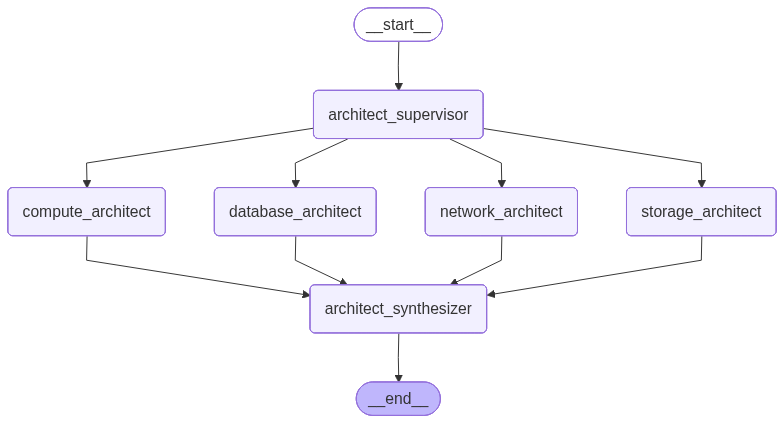

In [15]:
graph

In [16]:
result = graph.invoke({"user_problem": "I need a scalable web application that can handle 1000 requests per second."})
result

C:\Users\niran.NIRANJAN_GADE\AppData\Local\Temp\ipykernel_21124\3020526211.py:46: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.12/migration/
  "decomposition": response.dict(),


{'messages': [AIMessage(content='Task decomposition completed: I need a scalable web application that can handle 1000 requests per second.', additional_kwargs={}, response_metadata={}, id='c0da04fc-c6c2-4add-9eb4-a17629a8f14c'),
  AIMessage(content="To design a storage infrastructure that meets the specified requirements and architecture goals, we will consider the following components:\n\n### 1. Amazon S3 (Simple Storage Service)\n- **Buckets**: Create multiple S3 buckets to handle various types of content:\n  - **Raw Data Bucket**: For storing unprocessed data (e.g., user uploads, logs).\n  - **Static Content Bucket**: For serving static assets like images, CSS, JavaScript.\n- **Storage Classes**: Use appropriate S3 storage classes for cost optimization:\n  - **S3 Standard**: For frequently accessed data.\n  - **S3 Intelligent-Tiering**: For unpredictable access patterns.\n  - **S3 Glacier**: For archival data that is accessed infrequently.\n\n- **Lifecycle Policies**: Implement life

In [ ]:
for message in result["messages"]:
    pretty_print(message)